In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation


In [2]:
from src.modules.data_preprocessing import load_data
from src.modules.data_spliting import split_train_test
from src.modules.data_partition import data_partition
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import pandas as pd
from src.modules.iterative_imputation.distributed_imputer import DistributedFeatureImputer

## Load Data and set up clients

In [256]:
n_clients = 10
seed = 21

In [295]:
data, config = load_data('iris')
data_list = split_train_test(data, seed = 21)
train_data, test_data = data_list[0]
print(train_data.shape, test_data.shape)
n_cols = train_data.shape[1] - 1
config

(120, 5) (30, 5)


{'target': '5',
 'important_features_idx': [2, 3, 0, 1],
 'features_idx': [0, 1, 2, 3, 4],
 'num_cols': 4,
 'task_type': 'classification',
 'clf_type': 'multi-class',
 'data_type': 'tabular'}

## Data Partition

In [296]:
data_partitions = data_partition(
    strategy='full', params = {}, data=train_data.values, n_clients=n_clients, seed=seed
)
print("num partitions: {} size of data: {}".format(len(data_partitions), data_partitions[0].shape))

num partitions: 10 size of data: (120, 5)


## Add Missing Values to Clients

In [297]:
from src.fed_imp.sub_modules.missing_simulate.ms_simulate.mar_simulate import (
    simulate_nan_mary_quantile, simulate_nan_mar_quantile, simulate_nan_mar_sigmoid)
from src.fed_imp.sub_modules.missing_simulate.ms_simulate.mcar_simulate import simulate_nan_mcar

### MCAR

[12 12 12 12  0]
[36 36 36 36  0]
[60 60 60 60  0]
[84 84 84 84  0]
[108 108 108 108   0]
[12 12 12 12  0]
[36 36 36 36  0]
[60 60 60 60  0]
[84 84 84 84  0]
[108 108 108 108   0]


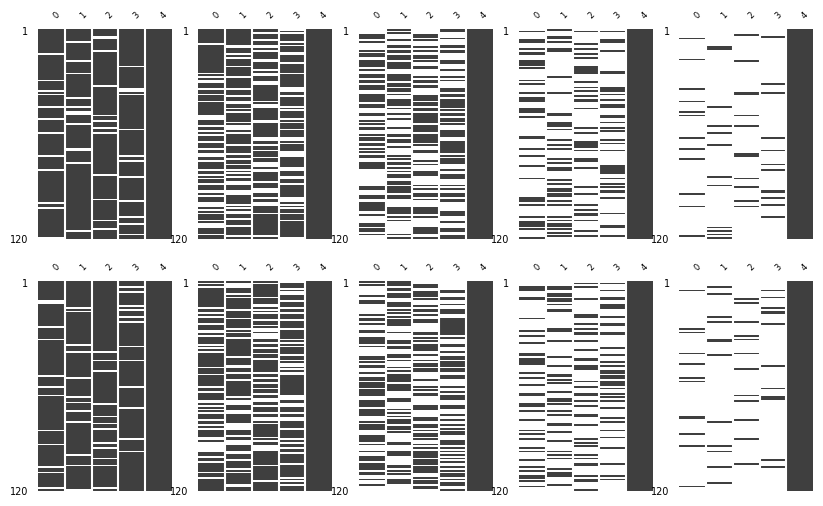

In [298]:
client_groups1 = [0, 1, 2, 3, 4]
client_groups2 = [5, 6, 7, 8, 9]
cols = [0, 1, 2, 3]
missing_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
train_data_ms_list = []
for idx, client in enumerate(client_groups1):
    seed = seed + 100
    train_data = data_partitions[client]
    X_train_ms = simulate_nan_mcar(train_data[:, :-1], cols = cols, missing_ratio=missing_ratios[idx], seed = seed)
    train_data_ms = np.concatenate((X_train_ms, train_data[:, -1].reshape(-1,1)), axis=1)
    print(np.isnan(train_data_ms).sum(axis = 0))
    train_data_ms_list.append(train_data_ms)

for idx, client in enumerate(client_groups2):
    seed = seed + 200
    train_data = data_partitions[client]
    X_train_ms = simulate_nan_mcar(train_data[:, :-1], cols = cols, missing_ratio=missing_ratios[idx], seed = seed)
    train_data_ms = np.concatenate((X_train_ms, train_data[:, -1].reshape(-1,1)), axis=1)
    print(np.isnan(train_data_ms).sum(axis = 0))
    train_data_ms_list.append(train_data_ms)

# visualization
fig, ax = plt.subplots(2, 5, figsize=(10, 6))
for i in range(10):
    msno.matrix(pd.DataFrame(train_data_ms_list[i]), ax=ax[i//5, i%5], sparkline=False, fontsize=6)
plt.show()

In [299]:
class Client:

    def __init__(self, X_train, y_train, X_train_ms):
        self.X_train = X_train
        self.y_train = y_train
        self.X_train_ms = X_train_ms
        self.mask = np.isnan(X_train_ms)
        self.X_train_filled = X_train_ms
        self.X_train_pt = None
        self.imputer = None

# client data
clients = []
for i in range(10):
    X_train, y_train = data_partitions[i][:, :-1], data_partitions[i][:, -1]
    X_train_ms = train_data_ms_list[i][:, :-1]
    clients.append(Client(X_train, y_train, X_train_ms))

imputer_list = []
for client in range(n_clients):
    client_obj = clients[client]
    client_obj.imp = DistributedFeatureImputer(client_obj.mask, estimator_num=None, estimator_cat='logistic_cv')

# initial imputation
global_mean = []
for client in range(n_clients):
    client_obj = clients[client]
    global_mean.append(np.nanmean(client_obj.X_train_ms, axis = 0))
global_mean = np.array(global_mean)
print(global_mean)

# avgerage initial imputation
mean_avg = np.nanmean(global_mean, axis = 0)
print(mean_avg)
for client in range(n_clients):
    client_obj = clients[client]
    for col in range(client_obj.X_train_ms.shape[1]):
        client_obj.X_train_filled[:, col] = np.where(client_obj.mask[:, col], mean_avg[col], client_obj.X_train_ms[:, col])
        client_obj.X_train_pt = client_obj.X_train_filled.copy()

[[0.42489712 0.43595679 0.46531701 0.45987654]
 [0.38955026 0.4375     0.468523   0.45882937]
 [0.39212963 0.43055556 0.48446328 0.4875    ]
 [0.41512346 0.4212963  0.42278719 0.50694444]
 [0.52083333 0.35069444 0.49435028 0.56597222]
 [0.41743827 0.43325617 0.43895166 0.47415123]
 [0.41005291 0.44890873 0.48930589 0.47519841]
 [0.42777778 0.43055556 0.47429379 0.44375   ]
 [0.4367284  0.43634259 0.47269303 0.41435185]
 [0.44675926 0.5        0.37429379 0.31944444]]
[0.42812904 0.43250661 0.45849789 0.46060185]


In [300]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
col_idx = 0
coefs = []
for client in range(n_clients):
    client_obj = clients[client]
    oh = OneHotEncoder(drop = 'first')
    target_onehot = oh.fit_transform(client_obj.y_train.reshape(-1, 1)).toarray()
    mask = np.arange(client_obj.X_train_filled.shape[1]) != col_idx
    X = np.concatenate([client_obj.X_train_filled[:, mask], target_onehot], axis = 1)
    y = client_obj.mask[:, col_idx]
    coef = []
    lr = LogisticRegressionCV(Cs = [1e-2], penalty = 'l2', cv=StratifiedKFold(5), random_state=0, max_iter=1000, n_jobs=-1, class_weight='balanced')
    #lr = LogisticRegression(C = 1e-2, penalty = 'l2', random_state=seed, max_iter=1000, n_jobs=-1)
    lr.fit(X, y)
    coef = np.concatenate([lr.coef_[0], lr.intercept_])
    coefs.append(coef)

coef_df = pd.DataFrame([coef for coef in coefs]).T
print(coef_df.T.apply(lambda row: np.linalg.norm(row, ord = 2)/len(row), axis = 1))
coef_df.corr(method = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)))

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.280185,0.195410,0.351188,0.006298,-0.214330,-0.068819,-0.398590,-0.163013,0.076227
1,0.280185,1.000000,0.875135,0.843008,0.049292,0.484973,0.739904,-0.630868,-0.297995,0.153613
2,0.195410,0.875135,1.000000,0.556797,0.355148,0.758186,0.914856,-0.210569,0.003736,0.446009
3,0.351188,0.843008,0.556797,1.000000,-0.438582,0.013460,0.448897,-0.890357,-0.751026,-0.358452
4,0.006298,0.049292,0.355148,-0.438582,1.000000,0.772318,0.393741,0.619789,0.866729,0.987612
5,-0.214330,0.484973,0.758186,0.013460,0.772318,1.000000,0.859724,0.352052,0.489713,0.783667
6,-0.068819,0.739904,0.914856,0.448897,0.393741,0.859724,1.000000,-0.019821,-0.004942,0.427364
7,-0.398590,-0.630868,-0.210569,-0.890357,0.619789,0.352052,-0.019821,1.000000,0.753061,0.534357
8,-0.163013,-0.297995,0.003736,-0.751026,0.866729,0.489713,-0.004942,0.753061,1.000000,0.853184
9,0.076227,0.153613,0.446009,-0.358452,0.987612,0.783667,0.427364,0.534357,0.853184,1.000000


In [301]:
coef_df

,0,1,2,3,4,5,6,7,8,9
0,-1.184249e-03,-0.015422,0.005404,-0.001499,-0.002739,0.003580,0.008529,0.014541,-0.008993,-0.006720
1,-8.166422e-03,0.026443,0.028309,0.004987,-0.012065,0.006042,0.008399,-0.006412,-0.003594,-0.006452
2,2.016468e-02,0.024402,0.019447,0.007485,0.001209,-0.006631,-0.001143,-0.015546,-0.003949,0.006983
3,-4.099383e-07,0.001600,-0.026903,0.011462,-0.050990,-0.025353,-0.010439,-0.028293,-0.033454,-0.050998
4,-3.424048e-04,0.054578,0.045494,0.011417,0.024456,0.025243,0.021850,-0.009873,-0.001086,0.024406
5,-5.484503e-03,-0.038785,-0.031095,-0.012529,0.019899,-0.003070,-0.011617,0.016472,0.019710,0.016464


In [302]:
coef_df.T.apply(lambda row: np.linalg.norm(row, ord = 2)/len(row), axis = 1)

0    0.003745
1    0.012929
2    0.011749
3    0.003734
4    0.010204
5    0.006197
6    0.004904
7    0.006798
8    0.006704
9    0.010004
dtype: float64

### MAR_quantile

[60 60 60  0  0]
[60 60 60  0  0]
[60 60 60  0  0]
[60 60 60  0  0]
[60 60 60  0  0]
[60 60 60  0  0]
[60 60 60  0  0]
[60 60 60  0  0]
[60 60 60  0  0]
[60 60 60  0  0]


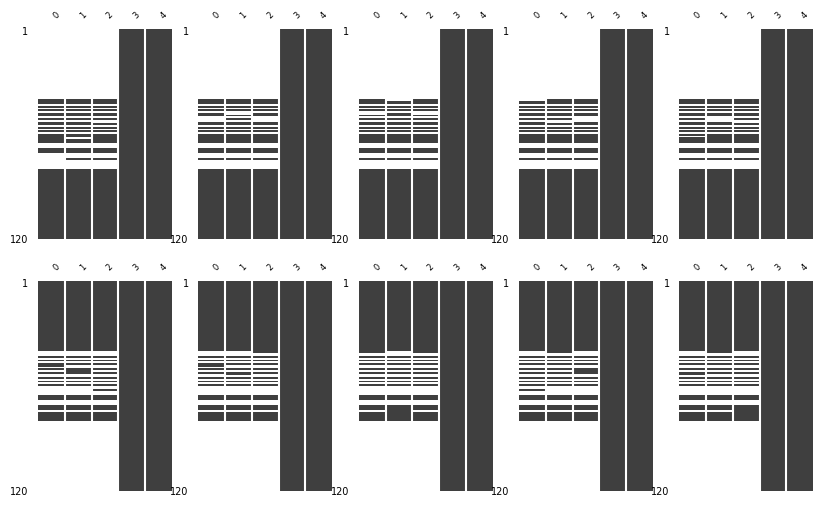

In [303]:
client_groups1 = [0, 1, 2, 3, 4]
client_groups2 = [5, 6, 7, 8, 9]
cols = [0, 1, 2]
missing_ratio1 = [0.5 for i in range(5)]
missing_ratio2 = [0.5 for i in range(5)]
train_data_ms_list = []
for idx, client in enumerate(client_groups1):
    seed = seed + 100
    train_data = data_partitions[client]
    X_train_ms = simulate_nan_mar_quantile(
        train_data[:, :-1], cols = cols, missing_ratio=missing_ratio1[idx], missing_func = 'left', obs=True, seed = seed)
    train_data_ms = np.concatenate((X_train_ms, train_data[:, -1].reshape(-1,1)), axis=1)
    print(np.isnan(train_data_ms).sum(axis = 0))
    train_data_ms_list.append(train_data_ms)

for idx, client in enumerate(client_groups2):
    seed = seed + 200
    train_data = data_partitions[client]
    X_train_ms = simulate_nan_mar_quantile(
        train_data[:, :-1], cols = cols, missing_ratio=missing_ratio2[idx], missing_func = 'right', obs=True, seed = seed)
    train_data_ms = np.concatenate((X_train_ms, train_data[:, -1].reshape(-1,1)), axis=1)
    print(np.isnan(train_data_ms).sum(axis = 0))
    train_data_ms_list.append(train_data_ms)

# visualization
fig, ax = plt.subplots(2, 5, figsize=(10, 6))
for i in range(10):
    msno.matrix(pd.DataFrame(train_data_ms_list[i]), ax=ax[i//5, i%5], sparkline=False, fontsize=6)
plt.show()

In [304]:
class Client:

    def __init__(self, X_train, y_train, X_train_ms):
        self.X_train = X_train
        self.y_train = y_train
        self.X_train_ms = X_train_ms
        self.mask = np.isnan(X_train_ms)
        self.X_train_filled = X_train_ms
        self.X_train_pt = None
        self.imputer = None

# client data
clients = []
for i in range(10):
    X_train, y_train = data_partitions[i][:, :-1], data_partitions[i][:, -1]
    X_train_ms = train_data_ms_list[i][:, :-1]
    clients.append(Client(X_train, y_train, X_train_ms))

imputer_list = []
for client in range(n_clients):
    client_obj = clients[client]
    client_obj.imp = DistributedFeatureImputer(client_obj.mask, estimator_num=None, estimator_cat='logistic_cv')

# initial imputation
global_mean = []
for client in range(n_clients):
    client_obj = clients[client]
    global_mean.append(np.nanmean(client_obj.X_train_ms, axis = 0))
global_mean = np.array(global_mean)
print(global_mean)

# avgerage initial imputation
mean_avg = np.nanmean(global_mean, axis = 0)
print(mean_avg)
for client in range(n_clients):
    client_obj = clients[client]
    for col in range(client_obj.X_train_ms.shape[1]):
        client_obj.X_train_filled[:, col] = np.where(client_obj.mask[:, col], mean_avg[col], client_obj.X_train_ms[:, col])
        client_obj.X_train_pt = client_obj.X_train_filled.copy()

[[0.58287037 0.39236111 0.70536723 0.45763889]
 [0.58287037 0.39305556 0.70451977 0.45763889]
 [0.58703704 0.38958333 0.70677966 0.45763889]
 [0.5787037  0.39027778 0.70451977 0.45763889]
 [0.58055556 0.39166667 0.70536723 0.45763889]
 [0.25509259 0.47916667 0.22146893 0.45763889]
 [0.25509259 0.48055556 0.22118644 0.45763889]
 [0.26342593 0.47986111 0.22118644 0.45763889]
 [0.2625     0.48125    0.22118644 0.45763889]
 [0.26203704 0.48125    0.22090395 0.45763889]]
[0.42101852 0.43590278 0.46324859 0.45763889]


In [306]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
col_idx = 0
coefs = []
for client in range(n_clients):
    client_obj = clients[client]
    oh = OneHotEncoder(drop = 'first')
    target_onehot = oh.fit_transform(client_obj.y_train.reshape(-1, 1)).toarray()
    mask = np.arange(client_obj.X_train_filled.shape[1]) != col_idx
    X = np.concatenate([client_obj.X_train_filled[:, mask], target_onehot], axis = 1)
    y = client_obj.mask[:, col_idx]
    coef = []
    lr = LogisticRegressionCV(Cs = [1e-2], penalty = 'l2', cv=StratifiedKFold(5), random_state=0, max_iter=1000, n_jobs=-1, class_weight='balanced')
    #lr = LogisticRegression(C = 1e-2, penalty = 'l2', random_state=seed, max_iter=1000, n_jobs=-1)
    lr.fit(X, y)
    coef = np.concatenate([lr.coef_[0], lr.intercept_])
    coefs.append(coef)

coef_df = pd.DataFrame([coef for coef in coefs]).T
print(coef_df.T.apply(lambda row: np.linalg.norm(row, ord = 2)/len(row), axis = 1))
coef_df.corr(method = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)))

0    0.049272
1    0.049396
2    0.049459
3    0.049187
4    0.049295
5    0.047941
6    0.047948
7    0.047835
8    0.047955
9    0.047949
dtype: float64


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.999988,0.999976,0.999984,0.999999,-0.998830,-0.998854,-0.998838,-0.998865,-0.998865
1,0.999988,1.000000,0.999997,0.999950,0.999990,-0.998761,-0.998788,-0.998746,-0.998802,-0.998800
2,0.999976,0.999997,1.000000,0.999937,0.999981,-0.998734,-0.998760,-0.998706,-0.998773,-0.998771
3,0.999984,0.999950,0.999937,1.000000,0.999985,-0.998904,-0.998920,-0.998918,-0.998927,-0.998927
4,0.999999,0.999990,0.999981,0.999985,1.000000,-0.998832,-0.998855,-0.998833,-0.998866,-0.998865
5,-0.998830,-0.998761,-0.998734,-0.998904,-0.998832,1.000000,0.999999,0.999983,0.999997,0.999997
6,-0.998854,-0.998788,-0.998760,-0.998920,-0.998855,0.999999,1.000000,0.999984,1.000000,1.000000
7,-0.998838,-0.998746,-0.998706,-0.998918,-0.998833,0.999983,0.999984,1.000000,0.999983,0.999984
8,-0.998865,-0.998802,-0.998773,-0.998927,-0.998866,0.999997,1.000000,0.999983,1.000000,1.000000
9,-0.998865,-0.998800,-0.998771,-0.998927,-0.998865,0.999997,1.000000,0.999984,1.000000,1.000000


### MAR sigmoid

[55 54 60  0  0]
[56 69 61  0  0]
[66 62 54  0  0]
[57 71 61  0  0]
[59 55 54  0  0]
[59 54 58  0  0]
[54 61 65  0  0]
[62 59 54  0  0]
[61 54 61  0  0]
[61 62 59  0  0]


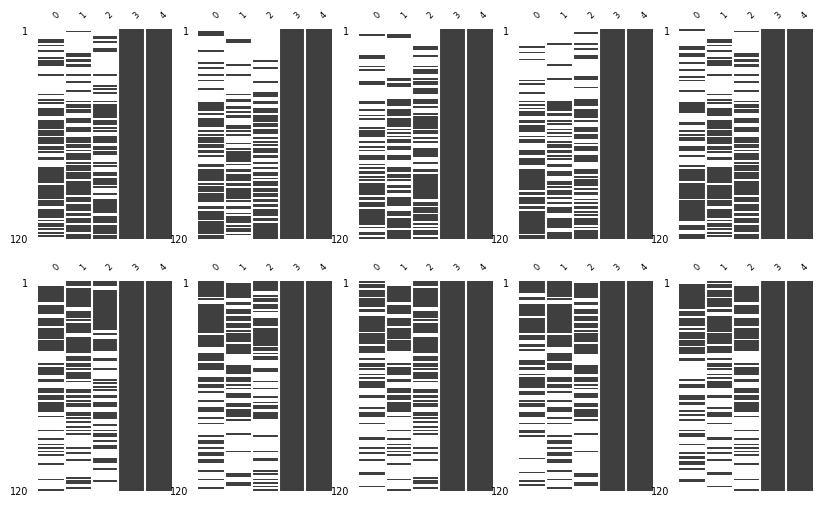

In [307]:
client_groups1 = [0, 1, 2, 3, 4]
client_groups2 = [5, 6, 7, 8, 9]
cols = [0, 1, 2]
missing_ratio = 0.5
train_data_ms_list = []
for client in client_groups1:
    seed = seed + 100
    train_data = data_partitions[client]
    X_train_ms = simulate_nan_mar_sigmoid(
        train_data[:, :-1], cols = cols, missing_ratio=missing_ratio, missing_func = 'left', obs=True, k = 'all', 
        seed = seed)
    train_data_ms = np.concatenate((X_train_ms, train_data[:, -1].reshape(-1,1)), axis=1)
    print(np.isnan(train_data_ms).sum(axis = 0))
    train_data_ms_list.append(train_data_ms)

for client in client_groups2:
    seed = seed + 200
    train_data = data_partitions[client]
    X_train_ms = simulate_nan_mar_sigmoid(
        train_data[:, :-1], cols = cols, missing_ratio=missing_ratio, missing_func = 'right', obs=True, k = 'all', 
        seed = seed)
    train_data_ms = np.concatenate((X_train_ms, train_data[:, -1].reshape(-1,1)), axis=1)
    print(np.isnan(train_data_ms).sum(axis = 0))
    train_data_ms_list.append(train_data_ms)

# visualization
fig, ax = plt.subplots(2, 5, figsize=(10, 6))
for i in range(10):
    msno.matrix(pd.DataFrame(train_data_ms_list[i]), ax=ax[i//5, i%5], sparkline=False, fontsize=6)
plt.show()

In [308]:
class Client:

    def __init__(self, X_train, y_train, X_train_ms):
        self.X_train = X_train
        self.y_train = y_train
        self.X_train_ms = X_train_ms
        self.mask = np.isnan(X_train_ms)
        self.X_train_filled = X_train_ms
        self.X_train_pt = None
        self.imputer = None

# client data
clients = []
for i in range(10):
    X_train, y_train = data_partitions[i][:, :-1], data_partitions[i][:, -1]
    X_train_ms = train_data_ms_list[i][:, :-1]
    clients.append(Client(X_train, y_train, X_train_ms))

imputer_list = []
for client in range(n_clients):
    client_obj = clients[client]
    client_obj.imp = DistributedFeatureImputer(client_obj.mask, estimator_num=None, estimator_cat='logistic_cv')

# initial imputation
global_mean = []
for client in range(n_clients):
    client_obj = clients[client]
    global_mean.append(np.nanmean(client_obj.X_train_ms, axis = 0))
global_mean = np.array(global_mean)
print(global_mean)

# avgerage initial imputation
mean_avg = np.nanmean(global_mean, axis = 0)
print(mean_avg)
for client in range(n_clients):
    client_obj = clients[client]
    for col in range(client_obj.X_train_ms.shape[1]):
        client_obj.X_train_filled[:, col] = np.where(client_obj.mask[:, col], mean_avg[col], client_obj.X_train_ms[:, col])
        client_obj.X_train_pt = client_obj.X_train_filled.copy()

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
col_idx = 0
coefs = []
for client in range(n_clients):
    client_obj = clients[client]
    oh = OneHotEncoder(drop = 'first')
    target_onehot = oh.fit_transform(client_obj.y_train.reshape(-1, 1)).toarray()
    mask = np.arange(client_obj.X_train_filled.shape[1]) != col_idx
    X = np.concatenate([client_obj.X_train_filled[:, mask], target_onehot], axis = 1)
    y = client_obj.mask[:, col_idx]
    coef = []
    lr = LogisticRegressionCV(Cs = [1e-2], penalty = 'l2', cv=StratifiedKFold(5), random_state=0, max_iter=1000, n_jobs=-1, class_weight='balanced')
    #lr = LogisticRegression(C = 1e-2, penalty = 'l2', random_state=seed, max_iter=1000, n_jobs=-1)
    lr.fit(X, y)
    coef = np.concatenate([lr.coef_[0], lr.intercept_])
    coefs.append(coef)

coef_df = pd.DataFrame([coef for coef in coefs]).T
print(coef_df.T.apply(lambda row: np.linalg.norm(row, ord = 2)/len(row), axis = 1))
coef_df.corr(method = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)))

[[0.50512821 0.40467172 0.57627119 0.45763889]
 [0.49305556 0.37254902 0.61706406 0.45763889]
 [0.50205761 0.40445402 0.55675398 0.45763889]
 [0.5207231  0.40646259 0.5794312  0.45763889]
 [0.50227687 0.40576923 0.58320493 0.45763889]
 [0.34107468 0.45454545 0.33078185 0.45763889]
 [0.34385522 0.46539548 0.31679507 0.45763889]
 [0.32806513 0.45013661 0.34745763 0.45763889]
 [0.35357815 0.45707071 0.32461936 0.45763889]
 [0.35310734 0.45617816 0.34009447 0.45763889]]
[0.42429219 0.4277233  0.45724737 0.45763889]
0    0.024291
1    0.028035
2    0.026186
3    0.034547
4    0.029878
5    0.026762
6    0.025819
7    0.028383
8    0.026288
9    0.025700
dtype: float64


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.990409,0.967492,0.978861,0.898810,-0.957285,-0.985547,-0.989276,-0.944066,-0.979976
1,0.990409,1.000000,0.990378,0.996724,0.948694,-0.985987,-0.993711,-0.993930,-0.971980,-0.962704
2,0.967492,0.990378,1.000000,0.997585,0.978916,-0.997966,-0.989202,-0.984907,-0.993266,-0.935547
3,0.978861,0.996724,0.997585,1.000000,0.969185,-0.995271,-0.995089,-0.992630,-0.986998,-0.952952
4,0.898810,0.948694,0.978916,0.969185,1.000000,-0.986279,-0.948471,-0.939540,-0.983540,-0.862022
5,-0.957285,-0.985987,-0.997966,-0.995271,-0.986279,1.000000,0.983395,0.980731,0.993708,0.925253
6,-0.985547,-0.993711,-0.989202,-0.995089,-0.948471,0.983395,1.000000,0.997508,0.980081,0.975538
7,-0.989276,-0.993930,-0.984907,-0.992630,-0.939540,0.980731,0.997508,1.000000,0.974433,0.981158
8,-0.944066,-0.971980,-0.993266,-0.986998,-0.983540,0.993708,0.980081,0.974433,1.000000,0.921403
9,-0.979976,-0.962704,-0.935547,-0.952952,-0.862022,0.925253,0.975538,0.981158,0.921403,1.000000


### MARY

[12 12 12 12  0]
[36 36 36 36  0]
[60 60 60 60  0]
[84 84 84 84  0]
[108 108 108 108   0]
[12 12 12 12  0]
[36 36 36 36  0]
[60 60 60 60  0]
[84 84 84 84  0]
[108 108 108 108   0]


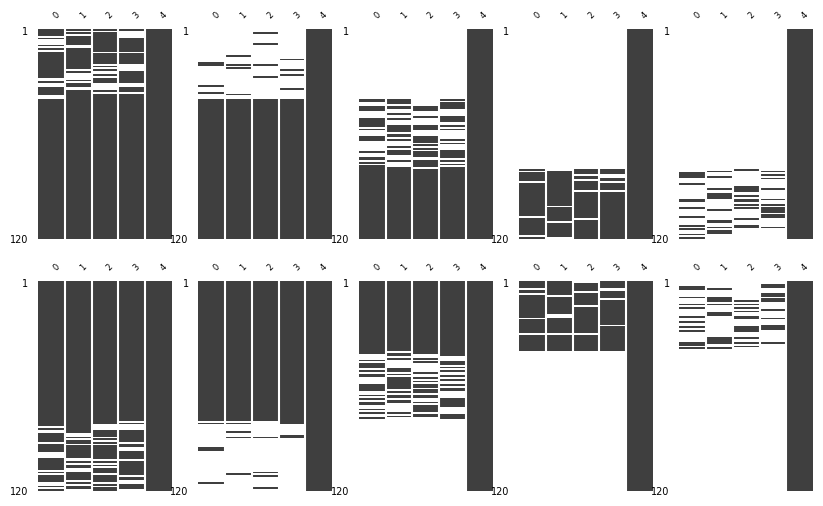

In [309]:
client_groups1 = [0, 1, 2, 3, 4]
client_groups2 = [5, 6, 7, 8, 9]
cols = [0, 1, 2, 3]
missing_ratio1 = [0.1, 0.3, 0.5, 0.7, 0.9]
missing_ratio2 = [0.1, 0.3, 0.5, 0.7, 0.9]
train_data_ms_list = []
for idx, client in enumerate(client_groups1):
    seed = seed + 100
    train_data = data_partitions[client]
    train_data_ms = simulate_nan_mary_quantile(
        train_data, cols = cols, missing_ratio=missing_ratio1[idx], missing_func='left', strict=True, seed = seed)
    print(np.isnan(train_data_ms).sum(axis = 0))
    train_data_ms_list.append(train_data_ms)

for idx, client in enumerate(client_groups2):
    seed = seed + 200
    train_data = data_partitions[client]
    train_data_ms = simulate_nan_mary_quantile(
        train_data, cols = cols, missing_ratio=missing_ratio2[idx], missing_func='right', strict=True, seed = seed)
    print(np.isnan(train_data_ms).sum(axis = 0))
    train_data_ms_list.append(train_data_ms)

# visualization
fig, ax = plt.subplots(2, 5, figsize=(10, 6))
for i in range(10):
    msno.matrix(pd.DataFrame(train_data_ms_list[i]), ax=ax[i//5, i%5], sparkline=False, fontsize=6)
plt.show()

In [310]:
class Client:

    def __init__(self, X_train, y_train, X_train_ms):
        self.X_train = X_train
        self.y_train = y_train
        self.X_train_ms = X_train_ms
        self.mask = np.isnan(X_train_ms)
        self.X_train_filled = X_train_ms
        self.X_train_pt = None
        self.imputer = None

# client data
clients = []
for i in range(10):
    X_train, y_train = data_partitions[i][:, :-1], data_partitions[i][:, -1]
    X_train_ms = train_data_ms_list[i][:, :-1]
    clients.append(Client(X_train, y_train, X_train_ms))

imputer_list = []
for client in range(n_clients):
    client_obj = clients[client]
    client_obj.imp = DistributedFeatureImputer(client_obj.mask, estimator_num=None, estimator_cat='logistic_cv')

# initial imputation
global_mean = []
for client in range(n_clients):
    client_obj = clients[client]
    global_mean.append(np.nanmean(client_obj.X_train_ms, axis = 0))
global_mean = np.array(global_mean)
print(global_mean)

# avgerage initial imputation
mean_avg = np.nanmean(global_mean, axis = 0)
print(mean_avg)
for client in range(n_clients):
    client_obj = clients[client]
    for col in range(client_obj.X_train_ms.shape[1]):
        client_obj.X_train_filled[:, col] = np.where(client_obj.mask[:, col], mean_avg[col], client_obj.X_train_ms[:, col])
        client_obj.X_train_pt = client_obj.X_train_filled.copy()

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
col_idx = 0
coefs = []
for client in range(n_clients):
    client_obj = clients[client]
    oh = OneHotEncoder(drop = 'first')
    target_onehot = oh.fit_transform(client_obj.y_train.reshape(-1, 1)).toarray()
    mask = np.arange(client_obj.X_train_filled.shape[1]) != col_idx
    X = np.concatenate([client_obj.X_train_filled[:, mask], target_onehot], axis = 1)
    y = client_obj.mask[:, col_idx]
    coef = []
    lr = LogisticRegressionCV(Cs = [1e-2], penalty = 'l2', cv=StratifiedKFold(5), random_state=0, max_iter=1000, n_jobs=-1, class_weight='balanced')
    #lr = LogisticRegression(C = 1e-2, penalty = 'l2', random_state=seed, max_iter=1000, n_jobs=-1)
    lr.fit(X, y)
    coef = np.concatenate([lr.coef_[0], lr.intercept_])
    coefs.append(coef)

coef_df = pd.DataFrame([coef for coef in coefs]).T
print(coef_df.T.apply(lambda row: np.linalg.norm(row, ord = 2)/len(row), axis = 1))
coef_df.corr(method = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)))

[[0.44547325 0.42013889 0.50502197 0.5007716 ]
 [0.51917989 0.36706349 0.62853107 0.63095238]
 [0.56574074 0.37222222 0.68587571 0.69930556]
 [0.60802469 0.38310185 0.74717514 0.7974537 ]
 [0.55092593 0.40625    0.74576271 0.79513889]
 [0.39531893 0.44097222 0.43298807 0.41782407]
 [0.34193122 0.45138889 0.33918483 0.31299603]
 [0.28842593 0.5        0.23728814 0.21388889]
 [0.19753086 0.58796296 0.07862524 0.05671296]
 [0.23148148 0.57986111 0.08757062 0.03819444]]
[0.41440329 0.45089616 0.44880235 0.44632385]
0    0.039629
1    0.041573
2    0.040721
3    0.060658
4    0.043873
5    0.053178
6    0.054933
7    0.039119
8    0.042495
9    0.028108
dtype: float64


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.935951,0.789595,0.567557,0.434197,-0.614867,-0.471656,-0.813968,-0.979742,-0.869137
1,0.935951,1.000000,0.835866,0.581468,0.502922,-0.614464,-0.508958,-0.819515,-0.981000,-0.952773
2,0.789595,0.835866,1.000000,0.928545,0.885023,-0.931017,-0.895325,-0.983472,-0.814936,-0.751547
3,0.567557,0.581468,0.928545,1.000000,0.976886,-0.990793,-0.985011,-0.913335,-0.561723,-0.470007
4,0.434197,0.502922,0.885023,0.976886,1.000000,-0.947364,-0.993466,-0.863262,-0.459226,-0.429052
5,-0.614867,-0.614464,-0.931017,-0.990793,-0.947364,1.000000,0.954459,0.905973,0.594709,0.476924
6,-0.471656,-0.508958,-0.895325,-0.985011,-0.993466,0.954459,1.000000,0.887122,0.485704,0.434617
7,-0.813968,-0.819515,-0.983472,-0.913335,-0.863262,0.905973,0.887122,1.000000,0.827512,0.765615
8,-0.979742,-0.981000,-0.814936,-0.561723,-0.459226,0.594709,0.485704,0.827512,1.000000,0.942781
9,-0.869137,-0.952773,-0.751547,-0.470007,-0.429052,0.476924,0.434617,0.765615,0.942781,1.000000


# Clustering

In [252]:
a = coef_df.corr(method = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)))
w = 1 - (a + 1)/2
w

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.077660,0.135407,0.247220,0.300218,0.758082,0.716937,0.898949,0.960508,0.872747
1,0.077660,0.000000,0.064107,0.221303,0.244715,0.768732,0.751694,0.910937,0.989541,0.985047
2,0.135407,0.064107,0.000000,0.056377,0.070070,0.934148,0.930521,0.984338,0.928319,0.913441
3,0.247220,0.221303,0.056377,0.000000,0.007639,0.998284,0.995631,0.944510,0.777951,0.739808
4,0.300218,0.244715,0.070070,0.007639,0.000000,0.986295,0.995678,0.924298,0.743815,0.731151
5,0.758082,0.768732,0.934148,0.998284,0.986295,0.000000,0.009982,0.062623,0.229976,0.279348
6,0.716937,0.751694,0.930521,0.995631,0.995678,0.009982,0.000000,0.065649,0.248264,0.273921
7,0.898949,0.910937,0.984338,0.944510,0.924298,0.062623,0.065649,0.000000,0.073871,0.114176
8,0.960508,0.989541,0.928319,0.777951,0.743815,0.229976,0.248264,0.073871,0.000000,0.029620
9,0.872747,0.985047,0.913441,0.739808,0.731151,0.279348,0.273921,0.114176,0.029620,0.000000


In [253]:
from sklearn.cluster import AgglomerativeClustering
a = coef_df.corr(method = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)))
w = 1 - (a + 1)/2
agg = AgglomerativeClustering(
		n_clusters=None, metric='cosine', linkage='average', distance_threshold=0.2
	)

agg.fit_predict(coef_df.T)

array([0, 0, 3, 3, 3, 1, 1, 1, 2, 2], dtype=int64)

- Algorithm 1
    - weighted average based on dissimilarity between missing mechaisms
        - alpha\*mech_dissimilarity + (1-alpha)\*(1- missing_rate)
- Algorithm 2
    - cluster based on missing mechanism distance
    - within cluster -> weighted average based on missing rate
    - find distance between clusters based on missing mechanism distance
     
    - For each client:
        - find the its cluster
        - weighted average based on distance between clsuters

- Algorithm 3
    - For every client:
        - cluster based on missing mechanism distance
        - within cluster -> weighted average based on missing rate
        - between clusters -> weighted average based on missing mechanism distance



In [249]:
print(agg.fit_predict(w))
agg.distances_

[0 0 3 3 3 1 1 1 2 2]


array([0.00763884, 0.00998235, 0.0296195 , 0.06322381, 0.06413624,
       0.07765958, 0.20216173, 0.20325916, 0.88565456])

In [255]:
coef_client = coef_df[0].values
coefs_centroid = coef_df.T.values
coef_df = pd.DataFrame([coef for coef in coefs_centroid]).T
coef_client = pd.Series(coef_client)
weight = coef_df.corrwith(coef_client, method=lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)))
weight = 1 - (weight + 1)/2
weight

0    0.000000
1    0.077660
2    0.135407
3    0.247220
4    0.300218
5    0.758082
6    0.716937
7    0.898949
8    0.960508
9    0.872747
dtype: float64